## Table of Contents

1. [Datasets](#dataset)<br>
2. [Total Imprisonment Rates](#2)<br>
    2a. [Visualization Pitfall](#3)<br>
    2b. [Population Dataset](#4)<br>
    2c. [Visualization Breakthrough, Observations, and interactive maps](#5)<br>
3. [State Imprisonment Distributions by Gender](#6)<br>
    3a. [Static Scatter Plots with Distributions](#7)<br>
    3b. [Interactive Scatter Plots](#8)<br>    
4. [Summary](#9)<br>

# Dataset: Taiwanese Credit Card Default Prediction <a id="dataset"></a>

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

this is where I expect the solutions to my issues will be: https://github.com/amueller/ml-training-advanced/blob/48162f50954a524ecb69b9d85de5233d886f8576/notebooks/extra%20-%20imbalanced%20datasets.ipynb

https://scipy2017.scipy.org/ehome/220975/493423/

In [13]:
# General Utility
import os
import pandas as pd
import numpy as np
import seaborn as sns
# import pickle
from scipy import interp
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.core.display import display, HTML
%matplotlib inline

In [187]:
# Preprocessing
import missingno as msno
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

In [15]:
# Model Building
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [190]:
# Model Validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [5]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid']


In [64]:
# Global
nb_seed = 1234
# plt.style.use('seaborn-darkgrid')
sns.set()

In [7]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format',lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = 10,10

In [182]:
def roc_plotter(fitted_clf, data_, labels_, ax=None):
    """
    Formats and plots the ROC curve and colors the curve by its 
      threshold value at each point.
    Args:
        fitted_clf:   A classifier that has already been fit to training data and labels
        test_data:    An array containing the corresponding testing data """
    if ax == None:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)
    y_pred_prob = fitted_clf.predict_proba(data_)[:,1]
    fpr, tpr, thresh = roc_curve(labels_, y_pred_prob) 
    mean_auc = auc(fpr, tpr)
    lc = colorline(ax, fpr, tpr, thresh)
    ax.plot(fpr, tpr, color='k',
            label='Mean ROC (AUC = {:0.2f})'
               .format(mean_auc), lw=1, alpha=0.5)
    ax.legend(loc='best', fancybox=True, framealpha=0.4)
    ax.set_title('ROC Curve', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    divider = make_axes_locatable(ax)
    fig = ax.get_figure()
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(lc, cax=cax, orientation='vertical')
    return ax

In [9]:
# Used the example at this address to encode threshold to color on the ROC curve # Used t 
# https://nbviewer.jupyter.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def colorline(ax, x, y, z=None, cmap='coolwarm', 
              norm=plt.Normalize(0.0, 1.0), linewidth=10, alpha=0.9):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    ax.add_collection(lc)
    return lc

In [114]:
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)
def confusion_mat_plotter(fitted_clf, X_train_, X_test_, y_train_, y_test_,
                           class_labels, cmap=g_cmap, ax=None):
    """
    Generates plots of the confusion matrices for a classifier's performance
      with both the training data (to check for overfitting) and the testing data.
    Args:
        fitted_clf:   A classifier that has already been fit to training data and labels
        X_train, ...  Arrays containing the training/testing data/labels."""
    if ax == None:
        fig, ax = plt.subplots(ncols=2, figsize=(13, 6.5))
    
    y_pred_train = fitted_clf.predict(X_train_)
    y_pred_test = fitted_clf.predict(X_test_)
    cfn_train = confusion_matrix(y_train_, y_pred_train)
    cfn_test = confusion_matrix(y_test_, y_pred_test)
    
    sns.heatmap(cfn_train.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax[0], cmap=g_cmap,
               annot_kws={"size": 16})
    ax[0].set_xlabel('True Class', fontsize=14)
    ax[0].set_ylabel('Predicted Class', fontsize=14)
    ax[0].set_title('Confusion Matrix (training data)', fontsize=14)
    sns.heatmap(cfn_test.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax[1], cmap=g_cmap,
               annot_kws={"size": 16})
    ax[1].set_xlabel('True Class', fontsize=14)
    ax[1].set_ylabel('Predicted Class', fontsize=14)
    ax[1].set_title('Confusion Matrix (testing data)', fontsize=14)
    plt.tight_layout()

In [11]:
# avg_cfn = np.mean(cfns, axis=0).astype(int)
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)
def confusion_mat_plotter_single(cfn_matrix, class_labels, cmap=g_cmap, ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cfn_matrix.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels, ax=ax, cmap=g_cmap,
               annot_kws={"size": 16})
    ax.set_xlabel('True Class', fontsize=14)
    ax.set_ylabel('Predicted Class', fontsize=14)
    ax.set_title('Confusion Matrix', fontsize=14)

In [12]:
CSV_PATH = os.path.join('data', 'taiwan_cc', 'default_of_credit_card_clients.csv')
cc_raw = pd.read_csv(CSV_PATH, encoding='latin1', index_col='ID')
cc_target = cc_raw['default_payment_next_month'] 
display(cc_target.head())
cc_data = cc_raw.drop('default_payment_next_month', axis=1)
display(cc_data.head())

ID
1    1
2    1
3    0
4    0
5    0
Name: default_payment_next_month, dtype: int64

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [17]:
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
dtypes: int64(23)
memory usage: 5.5 MB


In [18]:
cc_raw.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment_next_month'],
      dtype='object')

**From the plot below, we see that there is a significant class imbalance between the populations that did and did not default. To counteract this imbalance, I'll explore over-sampling and under-sampling strategies to balance the class counts.**

**We also see an imbalance between the number of men and women in the study, but as gender isn't a target variable, I won't balance for gender. **

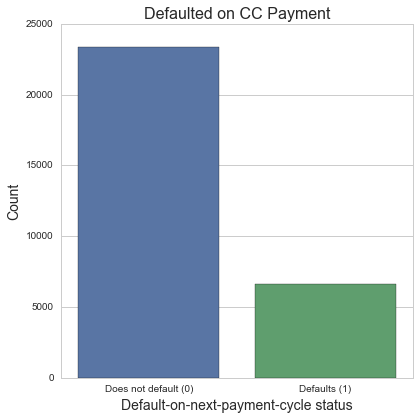

In [69]:
tmp = cc_raw[['default_payment_next_month','SEX']]
sex_dict = {1: 'Male', 2:'Female'}
tmp = tmp.replace({'SEX': sex_dict})

with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.countplot(x='default_payment_next_month', data=tmp, ax=ax)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status', fontsize=14)
    ax.set_title('Defaulted on CC Payment', fontsize=16)
    plt.tight_layout()

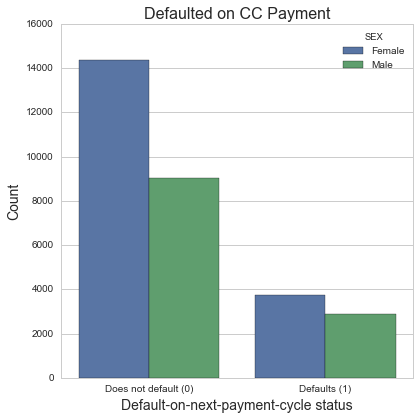

In [70]:
tmp = cc_raw[['default_payment_next_month','SEX']]
sex_dict = {1: 'Male', 2:'Female'}
tmp = tmp.replace({'SEX': sex_dict})

with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(6,6))
    sns.countplot(x='default_payment_next_month', hue='SEX', data=tmp, ax=ax)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status', fontsize=14)
    ax.set_title('Defaulted on CC Payment', fontsize=16)
    plt.tight_layout()

In [71]:
male_no_def = tmp[(tmp['SEX'] == 'Male') & (tmp['default_payment_next_month'] == 0)].count()[0]
female_no_def = tmp[(tmp['SEX'] == 'Female') & (tmp['default_payment_next_month'] == 0)].count()[0]
male_def = tmp[(tmp['SEX'] == 'Male') & (tmp['default_payment_next_month'] == 1)].count()[0]
female_def = tmp[(tmp['SEX'] == 'Female') & (tmp['default_payment_next_month'] == 1)].count()[0]

**We see that women were less likely to default on their credit.**

In [72]:
print('Males who didn\'t default: {:5d}, Females who didn\'t default: {:5d}'
      .format(male_no_def, female_no_def))
print('Males who did default: {:8d}, Females who did default: {:8d}'
      .format(male_def, female_def))
print('Percent of males who defaulted:   {:3.2f}%'.format(male_def*100/male_no_def))
print('Percent of females who defaulted: {:3.2f}%'.format(female_def*100/female_no_def))

Males who didn't default:  9015, Females who didn't default: 14349
Males who did default:     2873, Females who did default:     3763
Percent of males who defaulted:   31.87%
Percent of females who defaulted: 26.22%


**From the plot below, we see that several things.**
* **The third largest population completed high school,**
* **The plurality of the sampled population also went to university,**
* **The second largest population also completed grad school, and**
* **The remainder are either 'others' or in a column of 'unknown' values (these had values that weren't defined in the data description)**


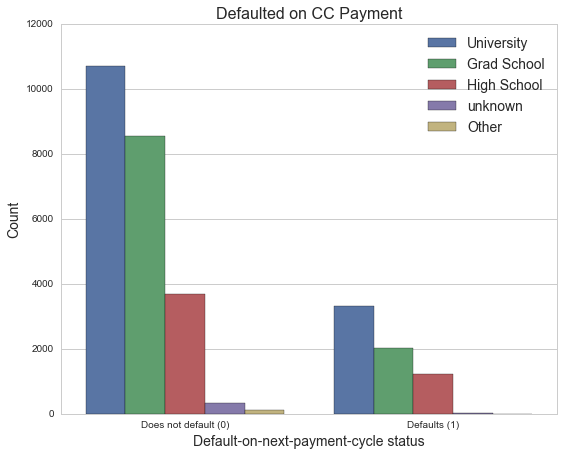

In [73]:
tmp = cc_raw[['default_payment_next_month','EDUCATION']]
edu_dict = {1:'Grad School',
            2:'University',
            3:'High School',
            4:'Other',
            5:'unknown',
            6:'unknown',
            0:'unknown'}
tmp = tmp.replace({'EDUCATION': edu_dict})

with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(8,6.5))
    sns.countplot(x='default_payment_next_month', hue='EDUCATION', data=tmp, ax=ax)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status', fontsize=14)
    ax.set_title('Defaulted on CC Payment', fontsize=16)
    ax.legend(loc='upper right', fontsize=14)
    plt.tight_layout()

In [24]:
uni_no_def = tmp[(tmp['EDUCATION'] == 'University') & (tmp['default_payment_next_month'] == 0)].count()[0]
grad_no_def = tmp[(tmp['EDUCATION'] == 'Grad School') & (tmp['default_payment_next_month'] == 0)].count()[0]
hs_no_def = tmp[(tmp['EDUCATION'] == 'High School') & (tmp['default_payment_next_month'] == 0)].count()[0]
other_no_def = tmp[(tmp['EDUCATION'] == 'Other') & (tmp['default_payment_next_month'] == 0)].count()[0]
unk_no_def = tmp[(tmp['EDUCATION'] == 'unknown') & (tmp['default_payment_next_month'] == 0)].count()[0]
uni_def = tmp[(tmp['EDUCATION'] == 'University') & (tmp['default_payment_next_month'] == 1)].count()[0]
grad_def = tmp[(tmp['EDUCATION'] == 'Grad School') & (tmp['default_payment_next_month'] == 1)].count()[0]
hs_def = tmp[(tmp['EDUCATION'] == 'High School') & (tmp['default_payment_next_month'] == 1)].count()[0]
other_def = tmp[(tmp['EDUCATION'] == 'Other') & (tmp['default_payment_next_month'] == 1)].count()[0]
unk_def = tmp[(tmp['EDUCATION'] == 'unknown') & (tmp['default_payment_next_month'] == 1)].count()[0]

**We see from the printouts below that 1.56% of the dataset is unknown or other. That's a **

In [25]:
print('University Grads who didn\'t default:  {:5d}, University Grads who did default:  {:5d}'
      .format(uni_no_def, uni_def))
print('Grad School Grads who didn\'t default: {:5d}, Grad School Grads who did default: {:5d}'
      .format(grad_no_def, grad_def))
print('High School Grads who didn\'t default: {:5d}, High School Grads who did default: {:5d}'
      .format(hs_no_def, hs_def))
print('Others who didn\'t default:            {:5d}, others who did default:            {:5d}'
      .format(other_no_def, other_def))
print('unknowns who didn\'t default:          {:5d}, unknowns who did default:          {:5d}'
      .format(unk_no_def, unk_def))
print('Percent of University grads who defaulted:   {:3.2f}%'.format(uni_def*100/uni_no_def))
print('Percent of Grad School grads who defaulted:  {:3.2f}%'.format(grad_def*100/grad_no_def))
print('Percent of High School grads who defaulted:  {:3.2f}%'.format(hs_def*100/hs_no_def))
print('Percent of Others who defaulted:             {:3.2f}%'.format(other_def*100/other_no_def))
print('Percent of Unknowns who defaulted:           {:3.2f}%'.format(unk_def*100/unk_no_def))
print('Percent of dataset that is unknown or other: {:3.2f}%'
      .format(100*(unk_def+unk_no_def+other_def+other_no_def)/cc_raw.shape[0]))

University Grads who didn't default:  10700, University Grads who did default:   3330
Grad School Grads who didn't default:  8549, Grad School Grads who did default:  2036
High School Grads who didn't default:  3680, High School Grads who did default:  1237
Others who didn't default:              116, others who did default:                7
unknowns who didn't default:            319, unknowns who did default:             26
Percent of University grads who defaulted:   31.12%
Percent of Grad School grads who defaulted:  23.82%
Percent of High School grads who defaulted:  33.61%
Percent of Others who defaulted:             6.03%
Percent of Unknowns who defaulted:           8.15%
Percent of dataset that is unknown or other: 1.56%


In [26]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

**I want to try imputing new values for the undefined education values, so I'll mark them as missing data (by making them NaN), and as I'm experimenting, I'll perform this step on a copy of the data.**

**note: I've included these print statements to confirm that I'm not changing the original dataframe (copy() only produces a shallow copy which copies values only if the element is a primitive, otherwise it copies the object address).**

In [82]:
cc_data_copy = cc_data.copy()
print('Pre-NaN:  cc_data["EDUCATION"].count(): {}'
      .format(cc_data['EDUCATION'].count()))
print('Pre-NaN:  cc_data_copy["EDUCATION"].count(): {}'
      .format(cc_data_copy['EDUCATION'].count()))

cc_data_copy.loc[cc_data_copy['EDUCATION'].isin([0,5,6]),'EDUCATION'] = np.nan

print('Post-NaN: cc_data["EDUCATION"].count(): {}'
      .format(cc_data['EDUCATION'].count()))
print('Post-NaN: cc_data_copy["EDUCATION"].count(): {}'
      .format(cc_data_copy['EDUCATION'].count()))

Pre-NaN:  cc_data["EDUCATION"].count(): 30000
Pre-NaN:  cc_data_copy["EDUCATION"].count(): 30000
Post-NaN: cc_data["EDUCATION"].count(): 30000
Post-NaN: cc_data_copy["EDUCATION"].count(): 29655


## Baseline model

**There are still a number of preprocessing steps that need to be performed (making dummy features for categorical features, implementing an under/over-sampling strategy to address the class imbalance), but let's implement a model  **

In [65]:
X_train, X_test, y_train, y_test = train_test_split(cc_data_copy, 
                                                    cc_target,
                                                    test_size=0.3,
                                                    random_state=nb_seed,
                                                    stratify=cc_target)

In [66]:
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
         ('r_forest', RandomForestClassifier())]
pipeline = Pipeline(steps)

             precision    recall  f1-score   support

          0       0.83      0.94      0.88      7009
          1       0.61      0.31      0.41      1991

avg / total       0.78      0.80      0.78      9000



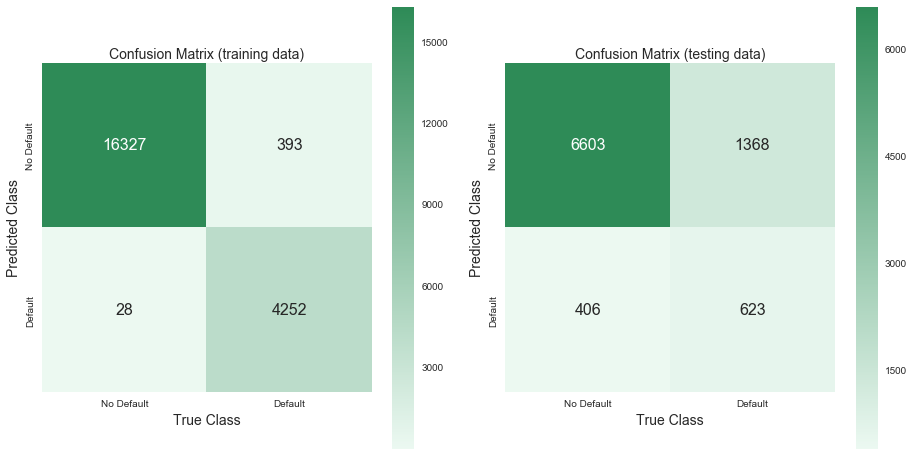

In [67]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(pipeline, X_train, X_test, y_train, y_test, ['No Default', 'Default'])

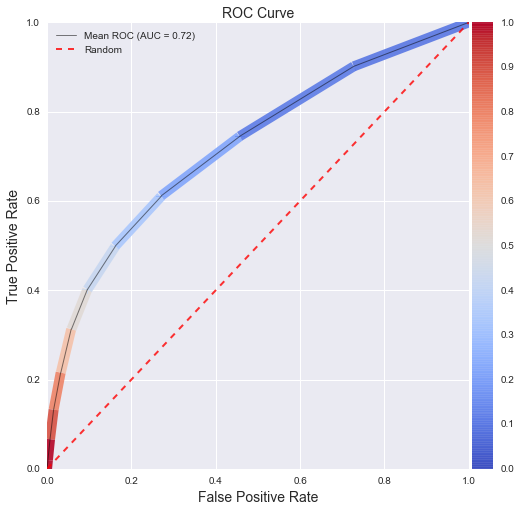

In [68]:
roc_plotter(pipeline, X_test, y_test)

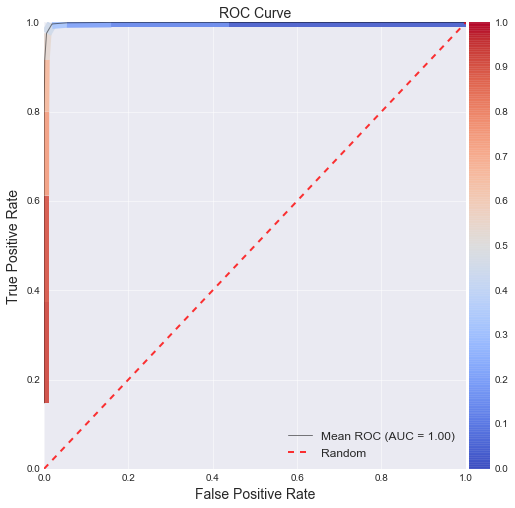

In [32]:
# This shows that the random forest perfectly fits the training data
#  as one should expect.
roc_plotter(pipeline, X_train, y_train)

In [33]:
cc_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    29655 non-null float64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
dtypes: float64(1), int64(22)
memory usage: 5.5 MB


**The features 'SEX', 'EDUCATION', and 'MARRIAGE' are definitely categorical, and the features 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', and 'PAY_6' are somewhat categorical. We should modify the type of those features to reflect that.**

In [34]:
cats = ['SEX','EDUCATION','MARRIAGE','PAY_0',
        'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
cc_tmp = cc_data_copy.copy()  # for use a little later

In [35]:
for cat in cats:
    cc_data_copy[cat] = cc_data_copy[cat].astype('category')

In [36]:
cc_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null category
EDUCATION    29655 non-null category
MARRIAGE     30000 non-null category
AGE          30000 non-null int64
PAY_0        30000 non-null category
PAY_2        30000 non-null category
PAY_3        30000 non-null category
PAY_4        30000 non-null category
PAY_5        30000 non-null category
PAY_6        30000 non-null category
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
dtypes: category(9), int64(14)
memory usage: 3.7 MB


**Changing the type of those 9 features reduced the memory usage from 5.5 MB to 3.7 MB, which is about a 33% reduction in size. In general, the length of time needed for a calculation depend on the memory footprint, so it's important to be mindful of memory usage. Granted this is a fairly small data set and the performance gain will be small, but in data sets that are 10, 100, or 1000+ as large, it can save hours of computation time. **

### Dummy Variables
We have to make dummy variables for categorical features so that scikit-learn classifiers can correctly interpret categorical features. The process of making dummy variables takes a categorical feature (eg MARRIAGE, which has 3 categories: [married, single, other]) and makes that one categorical feature column into multiple columns (1 for each unique category, eg [MARRIAGE_married, MARRIAGE_single, MARRIAGE_other]) that contain a 1 if the row is in that new column's category or a 0 if the row is not. 

We see from the printout below that making dummy variables for each unique value in the 9 categorical columns increased the number of columns from 23 to 79. While this will help scikit-learn correctly process these features, adding feature columns adds complexity and noise, which can promote overfitting and hurt a model's predictive power. Let's look at the same model again with this dummified data set.

In [84]:
dummy_df = pd.get_dummies(cc_data_copy, columns=cats, drop_first=True)

In [85]:
print('Number of feature columns before making dummy variables for categoricals: {:3}'
      .format(cc_data_copy.shape[1]))  
print('Number of feature columns after making dummy variables for categoricals:  {:3}'
      .format(dummy_df.shape[1]))

Number of feature columns before making dummy variables for categoricals:  23
Number of feature columns after making dummy variables for categoricals:   79


In [86]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df, 
                                                    cc_target,
                                                    test_size=0.3,
                                                    random_state=nb_seed,
                                                    stratify=cc_target)

In [87]:
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
         ('r_forest', RandomForestClassifier())]
pipeline = Pipeline(steps)

             precision    recall  f1-score   support

          0       0.83      0.94      0.88      7009
          1       0.61      0.32      0.42      1991

avg / total       0.78      0.80      0.78      9000



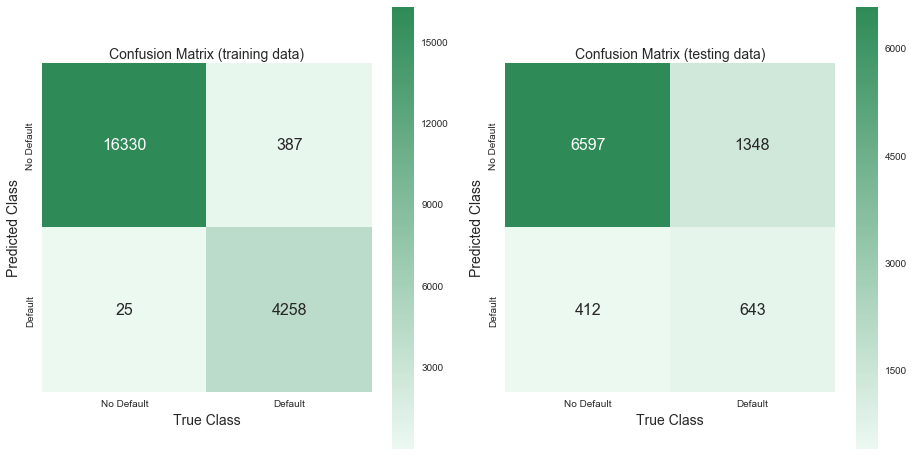

In [88]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(pipeline, X_train, X_test, y_train, y_test, ['No Default', 'Default'])

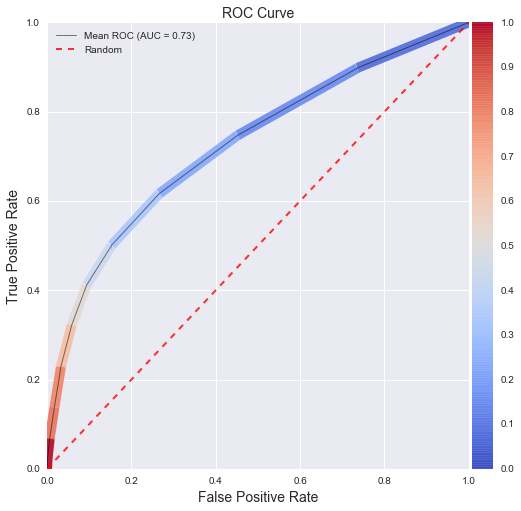

In [89]:
roc_plotter(pipeline, X_test, y_test)

### Observations after generating dummy variables

The precision in identifying cases of default is 0.61 rather than 0.60, which is a good sign, but it's too small to consider it statistically significant, especially considering we're just looking at 1 model. 

We did increase the number of features fairly significantly, and as there are only 8 columns that would come from previously discussed features (MARRIAGE: [maried, single, other], EDUCATION: [grad_school, university, high_school, other], and SEX: [male, female]) we know that the remaining ~50 columns are from the PAY features. Let's look at the distributions of values for these features.

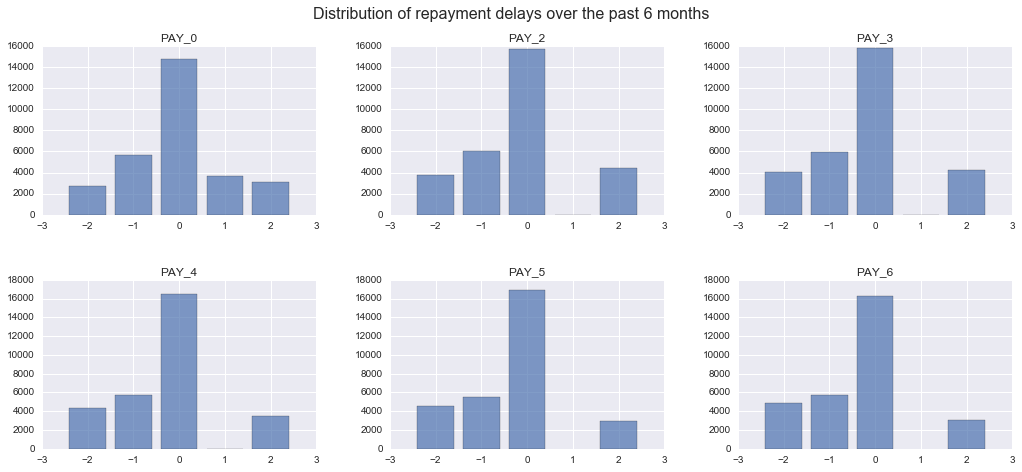

In [90]:
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(15,7)
    fig.suptitle('Distribution of repayment delays over the past 6 months', fontsize=16)
    
    for i in range(len(pay_cols)):
        row,col = (i//3, i%3)
        pay_data  = cc_tmp[pay_cols[i]].value_counts()
        ax[row,col].bar(pay_data.index, pay_data, align='center', alpha=0.7)
        ax[row,col].set_title(pay_cols[i], fontsize=12)
    plt.tight_layout(pad=3.0)

From the data set's documentation, we would not expect to see the values -2 or 0, but per (the Taiwanese professor that collected this data set)[https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608], -2 indicates no credit usage, and 0 indicates the person uses revolving credit (ie the credit user doesn't fully pay off their debt, but they do make at least the minimum payment). -1 indicates payment in full, and values above 0 indicate the number of months past due.

We also see that only a vanishingly small part of the population is more than 2 months behind on their bills, so I'll try lumping them into the 2 month bin. As -2 (no credit usage), -1 (pays in full every month), and 0 (revolving credit) seem like distinct types of behavior, I'll leave them as distinct categories.

In [91]:
rolldown_vals = [3,4,5,6,7,8,9,10]
# using another copy for convenience while developing
# cc_tmp = cc_data_copy.copy()
for feat in pay_cols:
    cc_tmp.loc[cc_data_copy[feat].isin([3,4,5,6,7,8,9]), feat] = 2

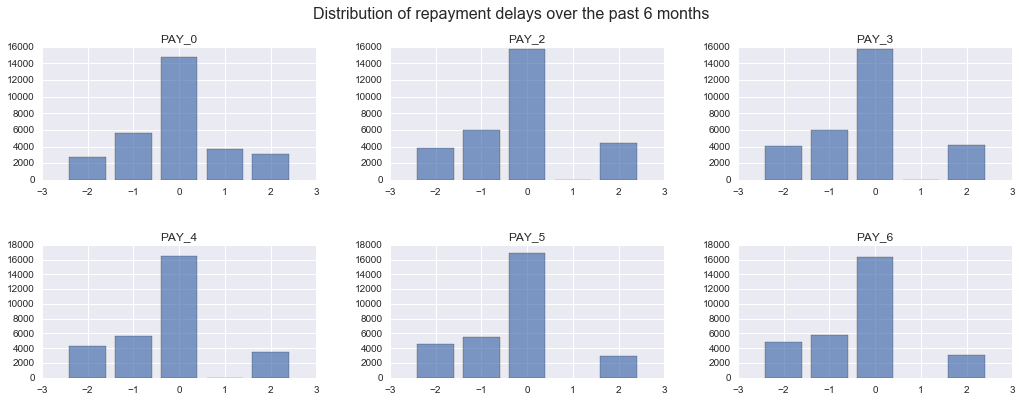

In [92]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(15,6)
    fig.suptitle('Distribution of repayment delays over the past 6 months', fontsize=16)
    
    for i in range(len(pay_cols)):
        row,col = (i//3, i%3)
        pay_data  = cc_tmp[pay_cols[i]].value_counts()
        ax[row,col].bar(pay_data.index, pay_data, align='center', alpha=0.7)
        ax[row,col].set_title(pay_cols[i], fontsize=12)
    plt.tight_layout(pad=3.0)

We see that we've successfully lumped the longer payment delays into the '2' category, which now means 'at least 2 months past due on payment'. I'll try making dummy variables from this smaller pool of categories.

In [93]:
cats = ['SEX','EDUCATION','MARRIAGE','PAY_0',
        'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
dummy_df = pd.get_dummies(cc_tmp, columns=cats, drop_first=True)

In [94]:
dummy_df.columns.values

array(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_2',
       'EDUCATION_2.0', 'EDUCATION_3.0', 'EDUCATION_4.0', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_0', 'PAY_0_1',
       'PAY_0_2', 'PAY_2_-1', 'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_3_-1',
       'PAY_3_0', 'PAY_3_1', 'PAY_3_2', 'PAY_4_-1', 'PAY_4_0', 'PAY_4_1',
       'PAY_4_2', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2', 'PAY_6_-1', 'PAY_6_0',
       'PAY_6_2'], dtype=object)

In [95]:
new_cats = []
for cat in cats:
    for col in dummy_df.columns.values:
        if cat in col:
            new_cats.append(col)

In [96]:
for cat in new_cats:
    dummy_df[cat] = dummy_df[cat].astype('category')

In [97]:
print('Number of feature columns before making dummy variables for categoricals: {:3}'
      .format(cc_tmp.shape[1]))  
print('Number of feature columns after making dummy variables for categoricals:  {:3}'
      .format(dummy_df.shape[1]))

Number of feature columns before making dummy variables for categoricals:  23
Number of feature columns after making dummy variables for categoricals:   43


In [98]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df, 
                                                    cc_target,
                                                    test_size=0.3,
                                                    random_state=nb_seed,
                                                    stratify=cc_target)

In [99]:
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
         ('r_forest', RandomForestClassifier())]
pipeline = Pipeline(steps)

             precision    recall  f1-score   support

          0       0.83      0.94      0.88      7009
          1       0.61      0.33      0.43      1991

avg / total       0.78      0.80      0.78      9000



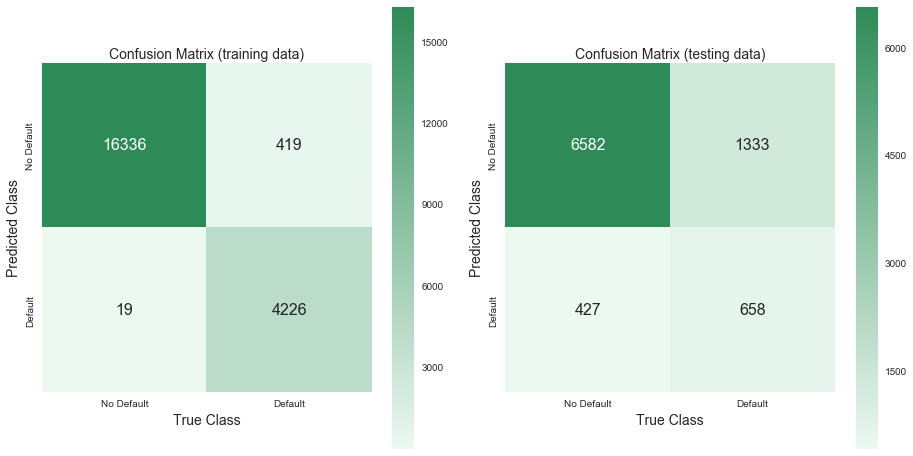

In [100]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(pipeline, X_train, X_test, y_train, y_test, ['No Default', 'Default'])

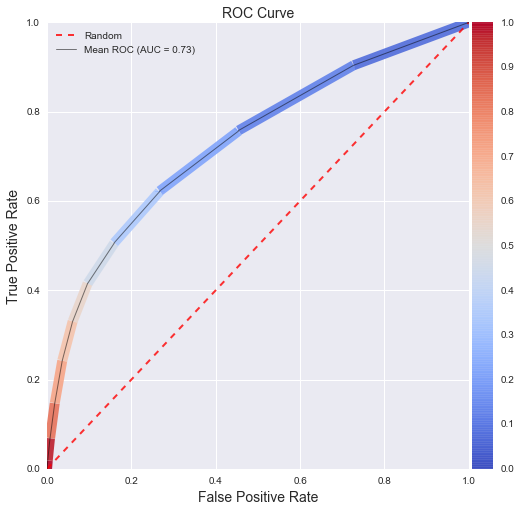

In [183]:
roc_plotter(pipeline, X_test, y_test)

**Again, we don't see a statistically significant improvement, but the data is in a better form for further analysis.**

## Handling Imbalanced Classes (SMOTE)

As we noted earlier, the number of observations where the credit-user defaulted is much, much smaller than the number where the credit-user did not default. This imbalance makes it more difficult for most machine learning algorithms to correctly classify cases. To address this, we can use an **oversampling** or **undersampling** algorithm to either (respectively) add more examples of the scarce class (credit default), or remove examples of the abundant class (no credit default). There are a number of over/under-sampling algorithms, and the more effective algorithms tend to be somewhat complex, but their impact can be incredible. 

**Synthetic Minority Oversampling TEchnique** (**SMOTE**) is one of the most popular oversampling algorithms. Without going into too much detain, the SMOTE algorithm creates synthetic examples to add to the data set using a process that doesn't bias the data set. You can read more about the [SMOTE algorithm in its whitepaper](https://arxiv.org/pdf/1106.1813.pdf), or see below for more detail.

#### General SMOTE algorithm (semi-technical)
Synthetic examples for the minority class are generated by taking each minority example (ie the row of values for each credit-default example), calculating the difference between that example of its nearest neighbor (ie the row of values most similar to that minority example), and multiply this difference by a random number between 0 and 1. If you need to generate more samples, you can repeat this process with the 2nd nearest neighbor, 3rd, 4th, etc.

This creates reasonable examples that are within the domain of the existing minority class data.

In [115]:
cc_data_copy = dummy_df

In [142]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df, 
                                                    cc_target,
                                                    test_size=0.3,
                                                    random_state=nb_seed,
                                                    stratify=cc_target)

             precision    recall  f1-score   support

          0       0.83      0.93      0.88      7009
          1       0.59      0.34      0.43      1991

avg / total       0.78      0.80      0.78      9000



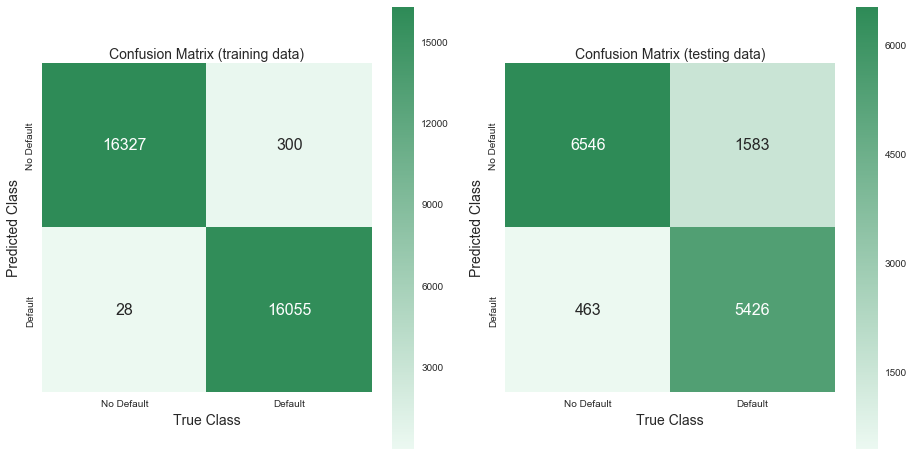

In [143]:
sm = SMOTE(random_state=nb_seed)
X_test_sm, y_test_sm = sm.fit_sample(X_test, y_test)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_sm, y_train_sm)
y_pred = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(clf_rf, X_train_sm, X_test_sm, y_train_sm, y_test_sm, ['No Default', 'Default'])

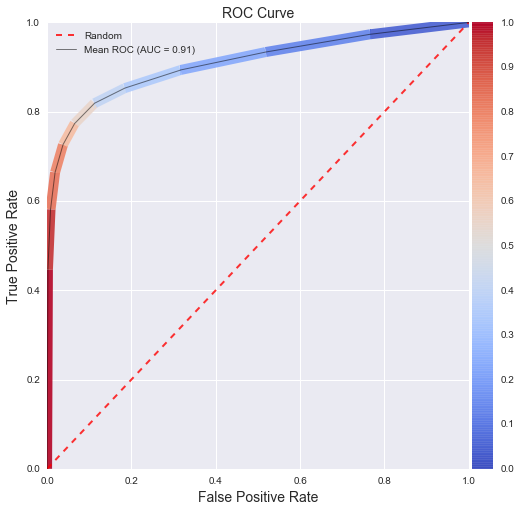

In [184]:
roc_plotter(clf_rf, X_test_sm, y_test_sm)

In [176]:
# y_train

In [181]:
clf_ = clf_rf
n=3
reps=1
thresh=0.5
skfolds = RepeatedStratifiedKFold(n_splits=n, n_repeats=reps, random_state=nb_seed)
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(clf_)
    X_train_fold = X_train.iloc[train_index.tolist()]
    y_train_fold = (y_train.iloc[train_index])
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = (y_train.loc[test_index])
    print('X_train_fold.shape: {}'.format(X_train_fold.shape))
    print('y_train_fold.shape: {}'.format(y_train_fold.shape))
    sm = SMOTE(random_state=nb_seed)
    X_train_fold_sm, y_train_fold_sm = sm.fit_sample(X_train_fold, y_train_fold)
    clone_clf.fit(X_train_fold_sm, y_train_fold_sm)
    y_pred = clone_clf.predict_proba(X_test_fold)[:,1]
#     y_pred = 1 if y_pred >= thresh else 0
    print(y_pred)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


X_train_fold.shape: (13999, 43)
y_train_fold.shape: (13999,)
[ 0.5  0.4  0.2 ...,  0.1  0.1  0.2]
0.1065562062562491
X_train_fold.shape: (14000, 43)
y_train_fold.shape: (14000,)


C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


[ 0.6  0.2  0.2 ...,  0.1  0.8  0.1]
0.10557142857142857
X_train_fold.shape: (14001, 43)
y_train_fold.shape: (14001,)


C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


[ 0.6  0.2  0.1 ...,  0.2  0.6  0. ]
0.10230032861837406


In [192]:
# smote_pipe = make_imb_pipeline(SMOTE(), RandomForestClassifier())
scores = cross_val_score(RandomForestClassifier(), X_train_sm, y_train_sm, cv=10, scoring='roc_auc')
scores

array([ 0.7615356 ,  0.76936637,  0.80273182,  0.99119745,  0.99172295,
        0.99360492,  0.99187517,  0.99144685,  0.9899365 ,  0.99219856])

In [152]:
clf_ = clf_rf
n=5
reps=2
skfolds = RepeatedStratifiedKFold(n_splits=n, n_repeats=reps, random_state=nb_seed)
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(clf_)
    X_train_fold = X_train[train_index]
    y_train_fold = (y_train[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train[test_index])
    
    sm = SMOTE(random_state=nb_seed)
    X_train_fold_sm, y_train_fold_sm = sm.fit_sample(X_train_fold, y_train_fold)
    clone_clf.fit(X_train_fold_sm, y_train_fold_sm)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

KeyError: '[    1     2     3 ..., 20997 20998 20999] not in index'

In [185]:
# X_train

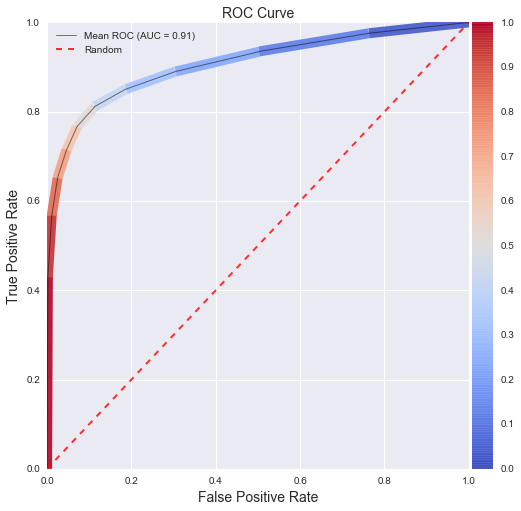

In [136]:
roc_plotter(clf_rf, X_test_sm, y_test_sm)

In [ ]:

parametersparamete  = {
    'criterion': ['entropy','gini'],
    'max_depth': [15,25,35],
    'min_samples_leaf': [1,4,6],
    'min_samples_split': [2,4],
    'random_state': [123]
}

dt_clf = tree.DecisionTreeClassifier()

dt_clf_gs = GridSearchCV(dt_clf, parameters, verbose=1, cv=5, n_jobs=-1)

In [62]:
skfolds = StratifiedKFold(n_splits=5, random_state=nb_seed)

for train_index, test_index in skfolds.split(cc_data_copy, cc_target):
    print('train_index.shape: {}'.format(train_index.shape))
    print('test_index.shape: {}'.format(test_index.shape))

train_index.shape: (23999,)
test_index.shape: (6001,)
train_index.shape: (24000,)
test_index.shape: (6000,)
train_index.shape: (24000,)
test_index.shape: (6000,)
train_index.shape: (24000,)
test_index.shape: (6000,)
train_index.shape: (24001,)
test_index.shape: (5999,)


In [104]:
cc_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 43 columns):
LIMIT_BAL        30000 non-null int64
AGE              30000 non-null int64
BILL_AMT1        30000 non-null int64
BILL_AMT2        30000 non-null int64
BILL_AMT3        30000 non-null int64
BILL_AMT4        30000 non-null int64
BILL_AMT5        30000 non-null int64
BILL_AMT6        30000 non-null int64
PAY_AMT1         30000 non-null int64
PAY_AMT2         30000 non-null int64
PAY_AMT3         30000 non-null int64
PAY_AMT4         30000 non-null int64
PAY_AMT5         30000 non-null int64
PAY_AMT6         30000 non-null int64
SEX_2            30000 non-null category
EDUCATION_2.0    30000 non-null category
EDUCATION_3.0    30000 non-null category
EDUCATION_4.0    30000 non-null category
MARRIAGE_1       30000 non-null category
MARRIAGE_2       30000 non-null category
MARRIAGE_3       30000 non-null category
PAY_0_-1         30000 non-null category
PAY_0_0          30000 non-null

In [107]:
tmp = cc_data_copy['EDUCATION']
edu_dict = {1:'Grad School',
            2:'University',
            3:'High School',
            4:'Other',
            5:'unknown',
            6:'unknown',
            0:'unknown'}
tmp = tmp.replace({'EDUCATION': edu_dict})

with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(8,6.5))
    sns.countplot(x='EDUCATION', data=tmp, ax=ax)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status', fontsize=14)
    ax.set_title('Defaulted on CC Payment', fontsize=16)
    ax.legend(loc='upper right', fontsize=14)
    plt.tight_layout()

KeyError: 'EDUCATION'

In [ ]:
pipeline = make_pipeline(Imputer(missing_values='NaN', strategy='most_frequent', axis=0),
                         RandomForestClassifier(random_state=nb_seed))
model = pipeline.fit(X_train, y_train)
prediction = model.predict(X_test)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(model, X_train, X_test, y_train, y_test, ['No Default', 'Default'])

In [ ]:
roc_plotter(model, X_test, y_test)

In [ ]:
smote_pipeline = make_imbPipeline(Imputer(missing_values='NaN', strategy='most_frequent', axis=0),
                                  SMOTE(random_state=nb_seed),
                                  RandomForestClassifier(random_state=nb_seed))
smote_model = smote_pipeline.fit(X_train, y_train)

In [ ]:
y_pred = smote_model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(smote_model, X_train, X_test, y_train, y_test, ['No Default', 'Default'])

In [ ]:
sm = SMOTE(random_state=nb_seed)

In [ ]:
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
         ('smote', SMOTE(random_state=nb_seed)),
         ('r_forest', RandomForestClassifier())]
smote_pipeline = imbPipeline(steps)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
smote_pipeline.fit(X_train, y_train)
y_pred = smote_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(smote_pipeline, X_train, X_test, y_train, y_test, ['No Default', 'Default'])

In [ ]:
roc_plotter(smote_pipeline, X_test, y_test)

In [ ]:
confusion_matrix(y_test, y_pred_test)

In [ ]:
from imblearn.metrics import classification_report_imbalanced

In [ ]:
print(classification_report(y_test, prediction))
print(classification_report_imbalanced(y_test, smote_prediction))

In [ ]:
from sklearn.model_selection import KFold

# cross validation done right
kf = KFold(n_splits=5, random_state=nb_seed)
accuracy = []
precision = []
recall = []
f1 = []
auc = []
for train, test in kf.split(X_train, y_train):
    pipeline = make_pipeline_imb(SMOTE(), classifier(random_state=nb_seed))
    model = pipeline.fit(X_train[train], y_train[train])
    prediction = model.predict(X_train[test])

    accuracy.append(pipeline.score(X_train[test], y_train[test]))
    precision.append(precision_score(y_train[test], prediction))
    recall.append(recall_score(y_train[test], prediction))
    f1.append(f1_score(y_train[test], prediction))
    auc.append(roc_auc_score(y_train[test], prediction))

In [ ]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_mat_plotter(confusion_matrix(y_test, y_pred), ['No Default', 'Default'])

In [ ]:
# y_pred_prob = pipeline.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
# roc_plotter(fpr, tpr, thresholds)
roc_plotter(pipeline, X_test)

In [ ]:
# y_pred_prob = pipeline.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
# roc_plotter(fpr, tpr, thresholds)
roc_plotter(pipeline, X_train)

In [ ]:
# tmp.loc[(tmp['EDUCATION'] == 'Other'),'EDUCATION'] = np.nan
type(fpr)

In [ ]:
# 
def roc_plotterz(ax_, fprs_, tprs_, threshs_, clf_type, pp_steps, DEBUG=False):
    tpr_set = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    if DEBUG:
        print('fprs_.shape: {}'.format(fprs_.shape))
        print('tprs_.shape: {}'.format(tprs_.shape))
        print('threshs_.shape: {}'.format(threshs_.shape))
    for i in range(len(fprs_)):
#         ax_.plot(fprs_[i], tprs_[i], lw=1, alpha=0.3)
        tpr_set.append(interp(mean_fpr, fprs_[i], tprs_[i]))
        tpr_set[-1][0] = 0.0
        roc_auc = auc(fprs_[i], tprs_[i])
        aucs.append(roc_auc)
        lc = colorline(ax_, fprs_[i], tprs_[i], threshs_[i])
        if DEBUG:
            print('[ROC plotter debug]: \ni: {}\nfprs_[i]: {}\ntprs_[i]: {}\nthreshs_[i]: {}'
                  .format(i, fprs_[i], tprs_[i], threshs_[i]))
    mean_tpr = np.mean(tpr_set, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tpr_set, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax_.plot(mean_fpr, mean_tpr, color='k',
            label='Mean ROC (AUC = {:0.2f} $\pm$ {:0.2f})'
               .format(mean_auc, std_auc), lw=1, alpha=0.8)
    ax_.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', 
                     alpha=.2, label='$\pm$ 1 std. dev.')
    ax_.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', 
               label='Random', alpha=.8)
    ax_.legend(loc='best', fancybox=True, framealpha=0.4)
    ax_.set_title('ROC Curve: Base Clf: [{}] \n Steps: [{}]'
                  .format(clf_type, pp_steps), fontsize=14)
    ax_.set_ylabel('True Positive Rate', fontsize=14)
    ax_.set_xlabel('False Positive Rate', fontsize=14)
    ax_.set_xlim([0.0,1.0])
    ax_.set_ylim([0.0,1.0])
    divider = make_axes_locatable(ax_)
    fig = ax_.get_figure()
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(lc, cax=cax, orientation='vertical')

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(x='SEX', data=cc_raw, ax=ax)
    ax.set_ylabel('Count', fontsize=12)
#     ax.set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax.set_xlabel('Default-on-next-payment-cycle status')
    ax.set_title('Defaulted on CC Payment')
    plt.tight_layout()

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
    sns.countplot(x='default_payment_next_month', data=cc_raw, ax=ax[0])
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax[0].set_xlabel('Default-on-next-payment-cycle status')
    ax[0].set_title('Defaulted on CC Payment')
    sns.countplot(x='AGE', data=cc_raw, hue='default_payment_next_month', ax=ax[1])
    ax[1].set_xlabel('Age [years]', fontsize=12)
    ax[1].set_ylabel('Count', fontsize=12)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right', fontsize=7.5)
    ax[1].legend(loc='upper right', title='Defaulted on CC Payment')
    ax[1].set_title('Age Distribution')

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,25))
    sns.countplot(x='default_payment_next_month', data=cc_raw, ax=ax[0,0])
    ax[0,0].set_ylabel('Count', fontsize=12)
    ax[0,0].set_xticklabels(['Does not default (0)', 'Defaults (1)'])
    ax[0,0].set_xlabel('Default-on-next-payment-cycle status')
    ax[0,0].set_title('Defaulted on CC Payment')
    sns.countplot(x='AGE', data=cc_raw, hue='default_payment_next_month', ax=ax[0,1])
    ax[0,1].set_xlabel('Age [years]', fontsize=12)
    ax[0,1].set_ylabel('Count', fontsize=12)
    ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=90, ha='right', fontsize=7.5)
    ax[0,1].legend(loc='upper right', title='Defaulted on CC Payment')
    ax[0,1].set_title('Age Distribution')
    sns.countplot(x='MARRIAGE', data=cc_raw, hue='default_payment_next_month', ax=ax[1,0])
    ax[1,0].set_xlabel('Married status', fontsize=12)
    ax[1,0].set_xticklabels(['Missing', 'Married', 'Single', 'Other'])
    ax[1,0].set_ylabel('Count', fontsize=12)
    ax[1,0].set_title('Marriage Distribution (1=Married, 2=Single, 3=Other)')
    sns.countplot(x='EDUCATION', data=cc_raw, hue='default_payment_next_month', ax=ax[1,1])
    ax[1,1].set_xlabel('', fontsize=12)
    ax[1,1].set_xticklabels(['Missing','Grad School','University','High School','Other','Missing','Missing'],
                         rotation=30)
    ax[1,1].set_ylabel('Count', fontsize=12)
    ax[1,1].set_title('Highest Completed Education Level Distribution') 
    
    sns.countplot(x='SEX', data=cc_raw, hue='default_payment_next_month', ax=ax[2,0])
    ax[2,0].set_xlabel('Gender', fontsize=12)
    ax[2,0].set_xticklabels(['Male', 'Female'])
    ax[2,0].set_ylabel('Count', fontsize=12)
    ax[2,0].set_title('Gender')
    # Not including a number of bins, distplot uses the Freedman-Diaconis rule by default
    sns.distplot(cc_raw['LIMIT_BAL'], norm_hist=False, kde=False, ax=ax[2,1])
    ax[2,1].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[2,1].set_ylabel('Count', fontsize=12)
    ax[2,1].set_title('Histogram of Credit Limits')
    sns.distplot(cc_raw['LIMIT_BAL'][cc_raw['default_payment_next_month']==0], 
                 norm_hist=False, kde=False, ax=ax[3,0])
    ax[3,0].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[3,0].set_ylabel('Count', fontsize=12)
    ax[3,0].set_title('Histogram of Credit Limits For Observations that Did Not Default')
    sns.distplot(cc_raw['LIMIT_BAL'][cc_raw['default_payment_next_month']==1], 
                 norm_hist=False, kde=False, ax=ax[3,1])
    ax[3,1].set_xlabel('Credit Limit (consumer and family credit) [NT dollars]', fontsize=12)
    ax[3,1].set_ylabel('Count', fontsize=12)
    ax[3,1].set_title('Histogram of Credit Limits For Observations that Defaulted')
plt.tight_layout

In [ ]:
from collections import Counter
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np


def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(f1_score(true_value, pred)))


# our classifier to use
classifier = RandomForestClassifier

data = fetch_datasets()['wine_quality']

# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], random_state=2)


# build normal model
pipeline = make_pipeline(classifier(random_state=42))
model = pipeline.fit(X_train, y_train)
prediction = model.predict(X_test)

# build model with SMOTE imblearn
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

# build model with undersampling
nearmiss_pipeline = make_pipeline_imb(NearMiss(random_state=42), classifier(random_state=42))
nearmiss_model = nearmiss_pipeline.fit(X_train, y_train)
nearmiss_prediction = nearmiss_model.predict(X_test)



# print information about both models
print()
print("normal data distribution: {}".format(Counter(data['target'])))
X_smote, y_smote = SMOTE().fit_sample(data['data'], data['target'])
print("SMOTE data distribution: {}".format(Counter(y_smote)))
X_nearmiss, y_nearmiss = NearMiss().fit_sample(data['data'], data['target'])
print("NearMiss data distribution: {}".format(Counter(y_nearmiss)))

# classification report
print(classification_report(y_test, prediction))
print(classification_report_imbalanced(y_test, smote_prediction))

print()
print('normal Pipeline Score {}'.format(pipeline.score(X_test, y_test)))
print('SMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
print('NearMiss Pipeline Score {}'.format(nearmiss_pipeline.score(X_test, y_test)))


print()
print_results("normal classification", y_test, prediction)
print()
print_results("SMOTE classification", y_test, smote_prediction)
print()
print_results("NearMiss classification", y_test, nearmiss_prediction)


from sklearn.model_selection import KFold

# cross validation done right
kf = KFold(n_splits=5, random_state=42)
accuracy = []
precision = []
recall = []
f1 = []
auc = []
for train, test in kf.split(X_train, y_train):
    pipeline = make_pipeline_imb(SMOTE(), classifier(random_state=42))
    model = pipeline.fit(X_train[train], y_train[train])
    prediction = model.predict(X_train[test])

    accuracy.append(pipeline.score(X_train[test], y_train[test]))
    precision.append(precision_score(y_train[test], prediction))
    recall.append(recall_score(y_train[test], prediction))
    f1.append(f1_score(y_train[test], prediction))
    auc.append(roc_auc_score(y_train[test], prediction))

print()
print("done right mean of scores 5-fold:")
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))
print()

# cross validation done wrong
kf = KFold(n_splits=5, random_state=42)
accuracy = []
precision = []
recall = []
f1 = []
auc = []
X, y = SMOTE().fit_sample(X_train, y_train)
for train, test in kf.split(X, y):
    pipeline = make_pipeline(classifier(random_state=42))
    model = pipeline.fit(X[train], y[train])
    prediction = model.predict(X[test])

    accuracy.append(pipeline.score(X[test], y[test]))
    precision.append(precision_score(y[test], prediction))
    recall.append(recall_score(y[test], prediction))
    f1.append(f1_score(y[test], prediction))

print("done wrong mean of scores 5-fold:")
print("accuracy: {}".format(np.mean(accuracy)))
print("precision: {}".format(np.mean(precision)))
print("recall: {}".format(np.mean(recall)))
print("f1: {}".format(np.mean(f1)))